<a href="https://colab.research.google.com/github/LeslyJaramillo/INTELIGENCIA-ARTIFICIAL/blob/main/Proyecto_de_Generacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam



In [ ]:
!pip install statsmodels --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.3
    Uninstalling statsmodels-0.14.3:
      Successfully uninstalled statsmodels-0.14.3


In [ ]:
df_viento = pd.read_csv('/content/datos_viento.xlsx - Export.csv')
df_viento.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-01-01,"30,2","21,7",33,0,NaN,98.0,"21,7",NaN,1011,NaN
1,2022-01-02,"30,7","25,3","33,4",0,NaN,101.0,24,NaN,"1011,9",NaN
2,2022-01-03,"30,3","24,7","33,4",0,NaN,93.0,"20,6",NaN,"1013,3",NaN
3,2022-01-04,"29,8","24,5","33,2",0,NaN,93.0,"17,9",NaN,"1012,1",NaN
4,2022-01-05,"28,4","23,1",32,0,NaN,82.0,"16,2",NaN,"1010,8",NaN


In [ ]:
df_viento.columns

Index(['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'tsun'],
      dtype='object')

In [ ]:
df_viento['wspd'] = pd.to_numeric(df_viento['wspd'].str.replace(',', '.'), errors='coerce')

In [ ]:
data = df_viento['wspd']

data.index = df_viento['wspd']
data.head()


,wspd
wspd,
21.7,21.7
24.0,24.0
20.6,20.6
17.9,17.9
16.2,16.2


In [ ]:
def SerieMatriz(timeSerie, predictionHorizonMax, window):
    timeSerie = np.squeeze(timeSerie)  # Elimina dimensiones adicionales

    # Inicializa X e y
    X = np.zeros([len(timeSerie) - predictionHorizonMax - window + 1, window])
    y = np.zeros([len(timeSerie) - predictionHorizonMax - window + 1, predictionHorizonMax])

    for i in range(X.shape[0]):
        X[i, :] = timeSerie[i:i + window]
        y[i, :] = timeSerie[i + window:i + window + predictionHorizonMax]

    return X, np.squeeze(y)  # Corregido

In [ ]:
#Parametros
predictionHorizonMax = 10
window = 10
neurons = 100
batch_size = 64
epochs = 100

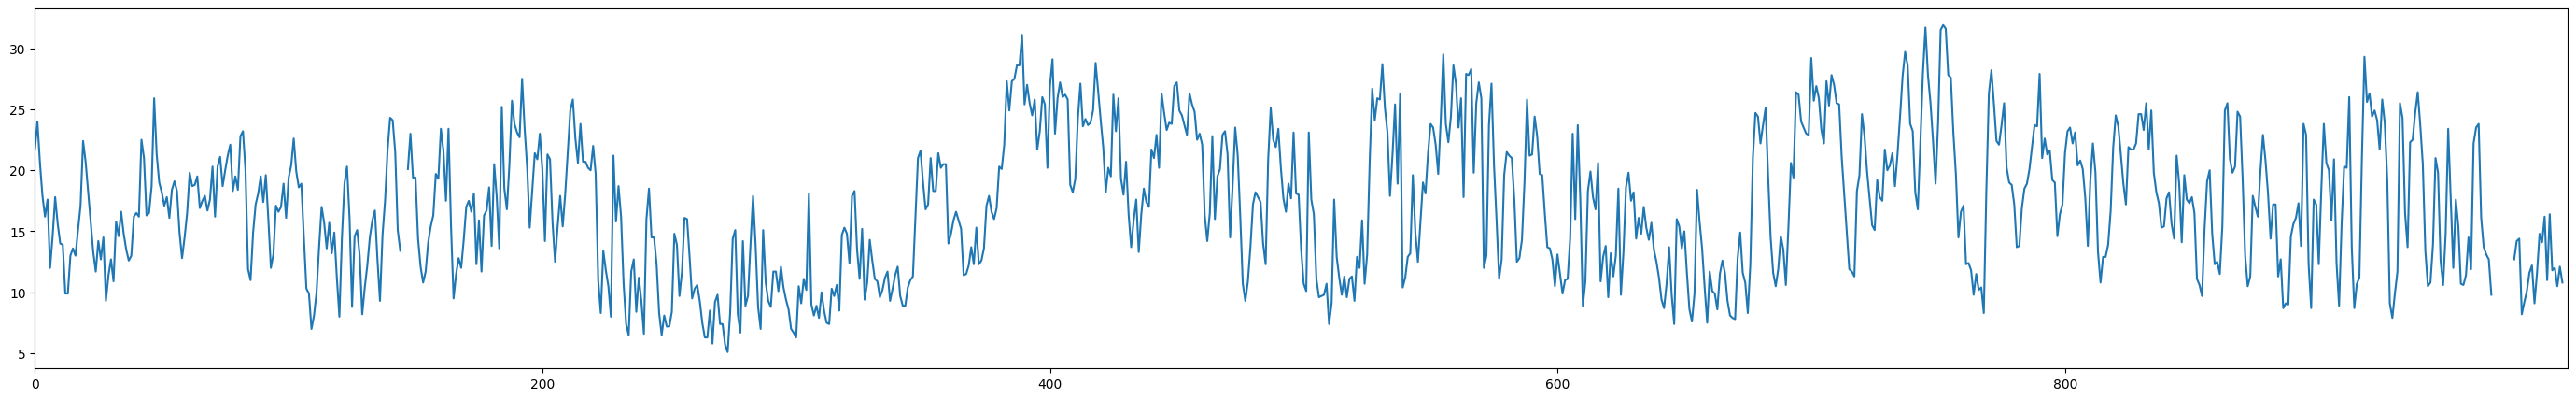

In [ ]:
#Graficar datos
timeSerie = data.values

plt.figure(figsize=(35, 5))
plt.plot(timeSerie)
plt.xlim(0, len(timeSerie))
plt.show()


In [ ]:
#Completar datos
timeSerie = np.array(timeSerie)
timeSerie_pd = pd.Series(timeSerie)

timeSerie_completa = timeSerie_pd.interpolate(method='linear')
print(timeSerie_completa)

0      21.7
1      24.0
2      20.6
3      17.9
4      16.2
       ... 
993    12.0
994    10.5
995    12.1
996    10.8
997    10.8
Length: 998, dtype: float64


In [ ]:
timeSerie = np.array(timeSerie_completa)

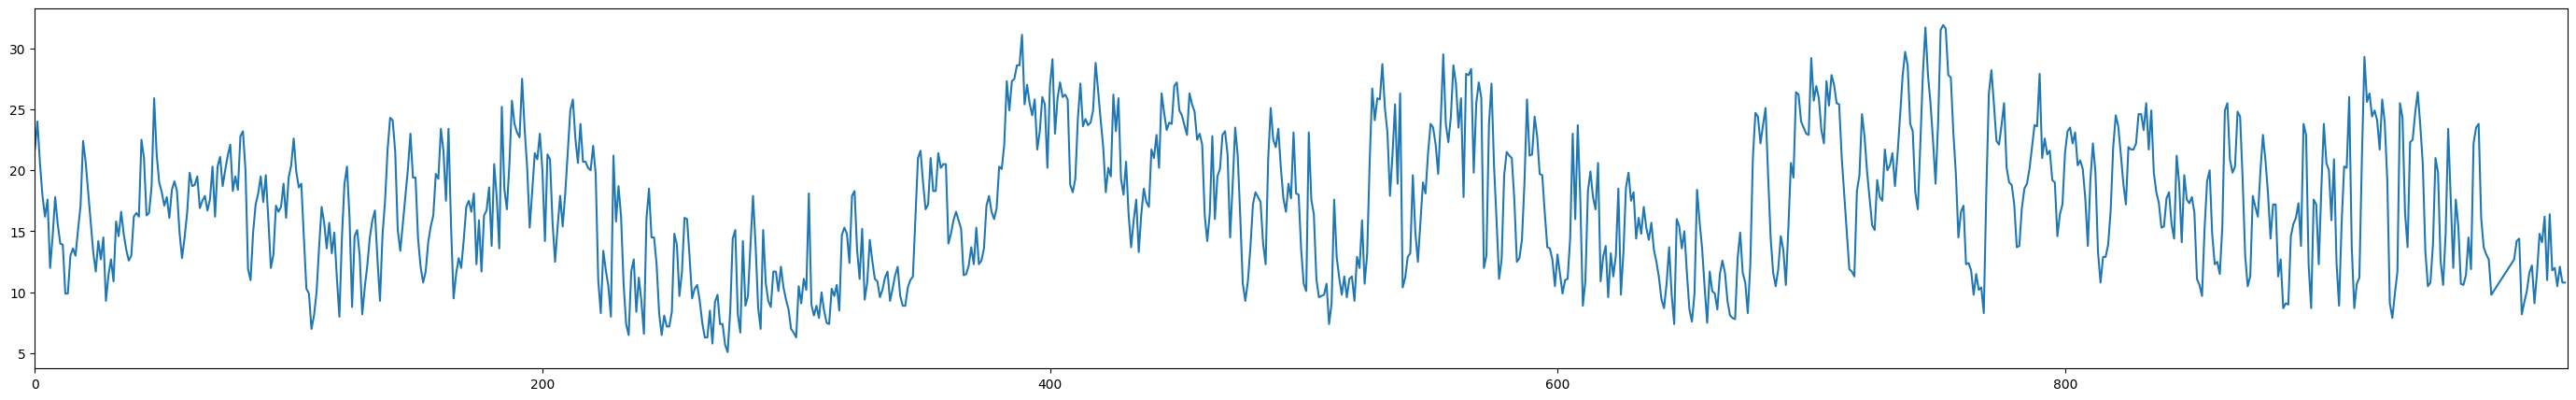

In [ ]:
#Graficar serie completa
plt.figure(figsize=(35, 5))
plt.plot(timeSerie)
plt.xlim(0, len(timeSerie))
plt.show()

In [ ]:

X_input = np.array(timeSerie)
time = np.arange(0, len(X_input), 1)
X_input.shape


(998,)

In [ ]:
# Normalizar la serie temporal
scaler = MinMaxScaler(feature_range=(0,1))
time = np.arange(0, len(timeSerie), 1)
timeSerieNormalized = scaler.fit_transform(timeSerie.reshape(-1,1))

# Generar las matrices X (características) e y (etiquetas) usando la función SerieMatriz
X, y = SerieMatriz(timeSerieNormalized, predictionHorizonMax, window)
#Datos de test y validación
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.20, random_state=42)

X.shape, y.shape, X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((979, 10),
 (979, 10),
 (626, 10),
 (157, 10),
 (196, 10),
 (626, 10),
 (157, 10),
 (196, 10))

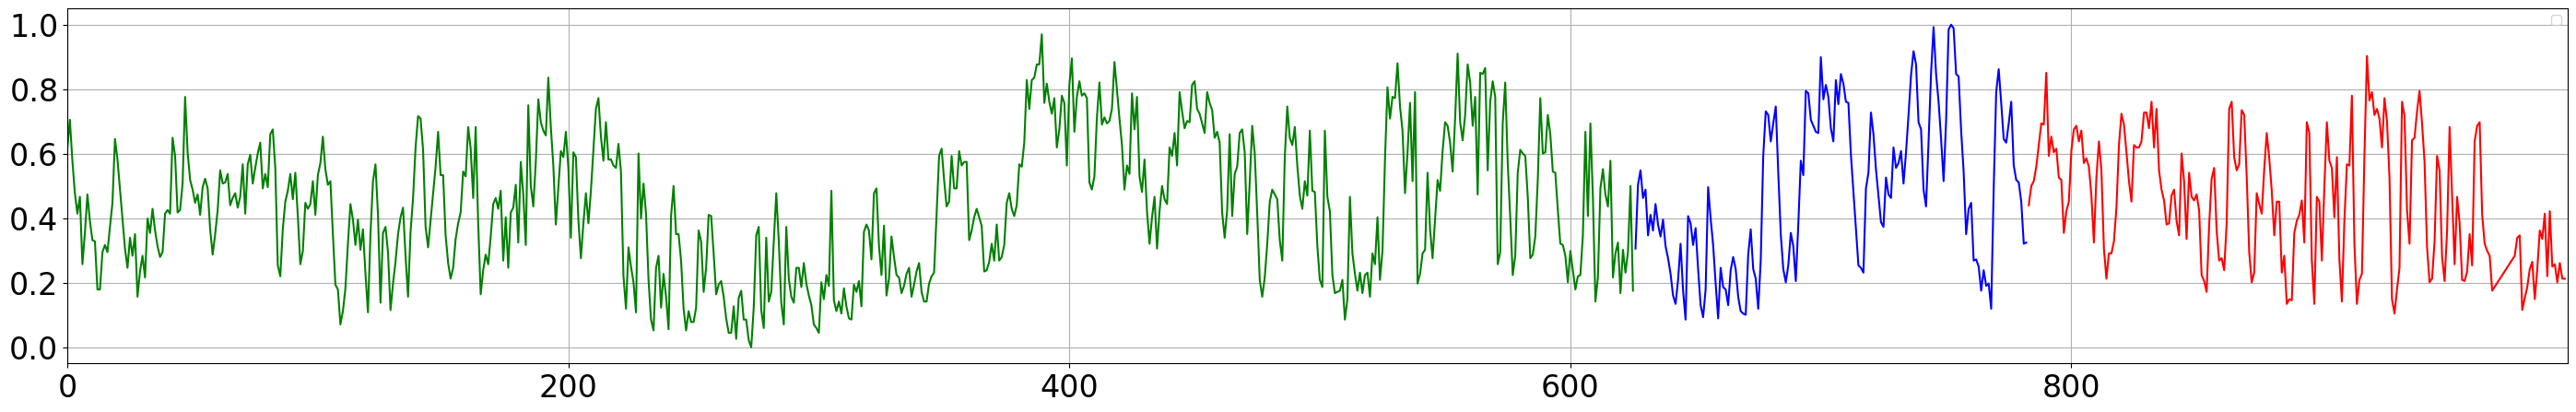

In [ ]:
# Ploter el conjunto de datos
plt.figure(figsize=(35,5))
plt.plot(time[0:X_train.shape[0]], timeSerieNormalized[0:X_train.shape[0]], 'g')
plt.plot(time[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], timeSerieNormalized[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], 'b')
plt.plot(time[X_train.shape[0]+X_valid.shape[0]:], timeSerieNormalized[X_train.shape[0]+X_valid.shape[0]:], 'r')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0,timeSerie.shape[0])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Redimensionamiento de los datos de entrenamiento, validación y prueba
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((626, 10, 1), (157, 10, 1), (196, 10, 1), (626, 10), (157, 10), (196, 10))

# RNN

In [ ]:

input = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]), name='Input')
rnn_1 = tf.keras.layers.SimpleRNN(neurons, activation='relu', return_sequences=True, name='h1')(input)
rnn_2 = tf.keras.layers.SimpleRNN(neurons, activation='relu', return_sequences=True, name='h2')(rnn_1)
rnn_3 = tf.keras.layers.SimpleRNN(neurons, activation='relu', return_sequences=True, name='h3')(rnn_2)
rnn_4 = tf.keras.layers.SimpleRNN(neurons, activation='relu', return_sequences=True, name='h4')(rnn_3)
rnn_5 = tf.keras.layers.SimpleRNN(neurons, activation='relu', return_sequences=True, name='h5')(rnn_4)
output = keras.layers.SimpleRNN(predictionHorizonMax)(rnn_5)


model_RNNSimple = tf.keras.Model(inputs=input, outputs=output)


In [ ]:
model_RNNSimple.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae'])
history_RNNSimple = model_RNNSimple.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)



In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((626, 10, 1), (157, 10, 1), (196, 10, 1), (626, 10), (157, 10), (196, 10))

In [ ]:
forecasting_RNNSimple = model_RNNSimple.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step


In [ ]:
col_names, MSE, RMSE, MAE, R2 = ['Metrics'], ["MSE"], ["RMSE"], ["MAE"], ["R2"]

for k in range(predictionHorizonMax):
  col_names.append(str(k+1))
  MSE.append(round(mean_squared_error(y_test[:,k], forecasting_RNNSimple[:,k], squared=False), 2))
  RMSE.append(round(mean_squared_error(y_test[:,k], forecasting_RNNSimple[:,k], squared=True), 2))
  MAE.append(round(mean_absolute_error(y_test[:,k], forecasting_RNNSimple[:,k]), 2))


data = [MSE, RMSE, MAE]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│ Metrics   │    1 │    2 │    3 │    4 │    5 │    6 │    7 │    8 │    9 │   10 │
╞═══════════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╡
│ MSE       │ 0.16 │ 0.18 │ 0.2  │ 0.22 │ 0.21 │ 0.22 │ 0.21 │ 0.22 │ 0.24 │ 0.23 │
├───────────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ RMSE      │ 0.03 │ 0.03 │ 0.04 │ 0.05 │ 0.04 │ 0.05 │ 0.05 │ 0.05 │ 0.06 │ 0.05 │
├───────────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ MAE       │ 0.12 │ 0.15 │ 0.16 │ 0.18 │ 0.17 │ 0.17 │ 0.17 │ 0.18 │ 0.19 │ 0.18 │
╘═══════════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╛


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

In [ ]:
model_RNNSimple.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h1 (SimpleRNN)                       │ (None, 10, 100)             │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h2 (SimpleRNN)                       │ (None, 10, 100)             │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h3 (SimpleRNN)                       │ (None, 10, 100)             │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h4 (SimpleRNN)                       │ (None, 10, 100)             │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h5 (SimpleRNN)                       │ (None, 10, 100)             │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 10)                  │           1,110 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 275,132 (1.05 MB)

 Trainable params: 91,710 (358.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 183,422 (716.50 KB)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(626, 10, 1)
(196, 10, 1)


In [ ]:
# Obtener las predicciones del modelo entrenado para los conjuntos de entrenamiento y prueba
trainPredict = model_RNNSimple.predict(X_train)
testPredict = model_RNNSimple.predict(X_test)

print(trainPredict.shape)
print(testPredict.shape)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(626, 10)
(196, 10)


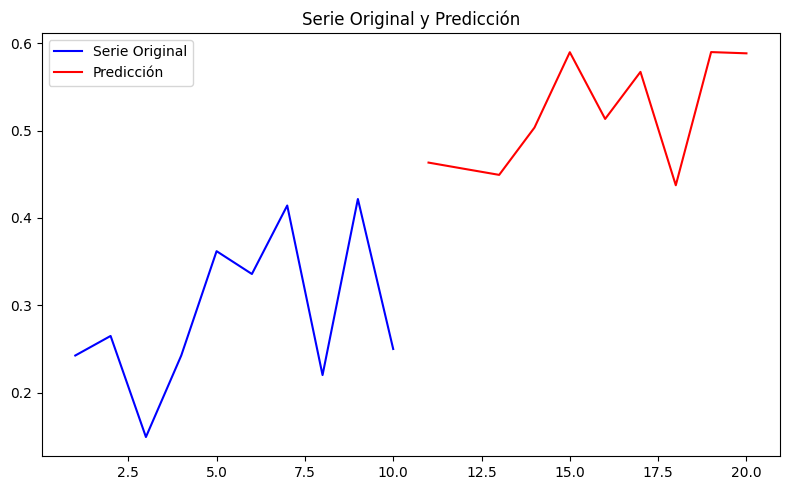

In [ ]:
##SERI Y PREDICCIÓN
n_last = 10

y_last = y_test.flatten()[-n_last:]
prediction_last = testPredict.flatten()[:n_last]

time_steps_original = list(range(1, n_last + 1))
time_steps_prediction = list(range(n_last + 1, 2 * n_last + 1))


plt.figure(figsize=(8, 5))
plt.plot(time_steps_original, y_last, label="Serie Original", color="blue", linestyle='-')
plt.plot(time_steps_prediction, prediction_last, label="Predicción", color="red", linestyle='-')

plt.title("Serie Original y Predicción")
plt.legend()


plt.tight_layout()
plt.show()


In [ ]:
print("Forma de trainPredict:", trainPredict.shape)
print("Forma de testPredict:", testPredict.shape)

Forma de trainPredict: (664,)
Forma de testPredict: (326,)


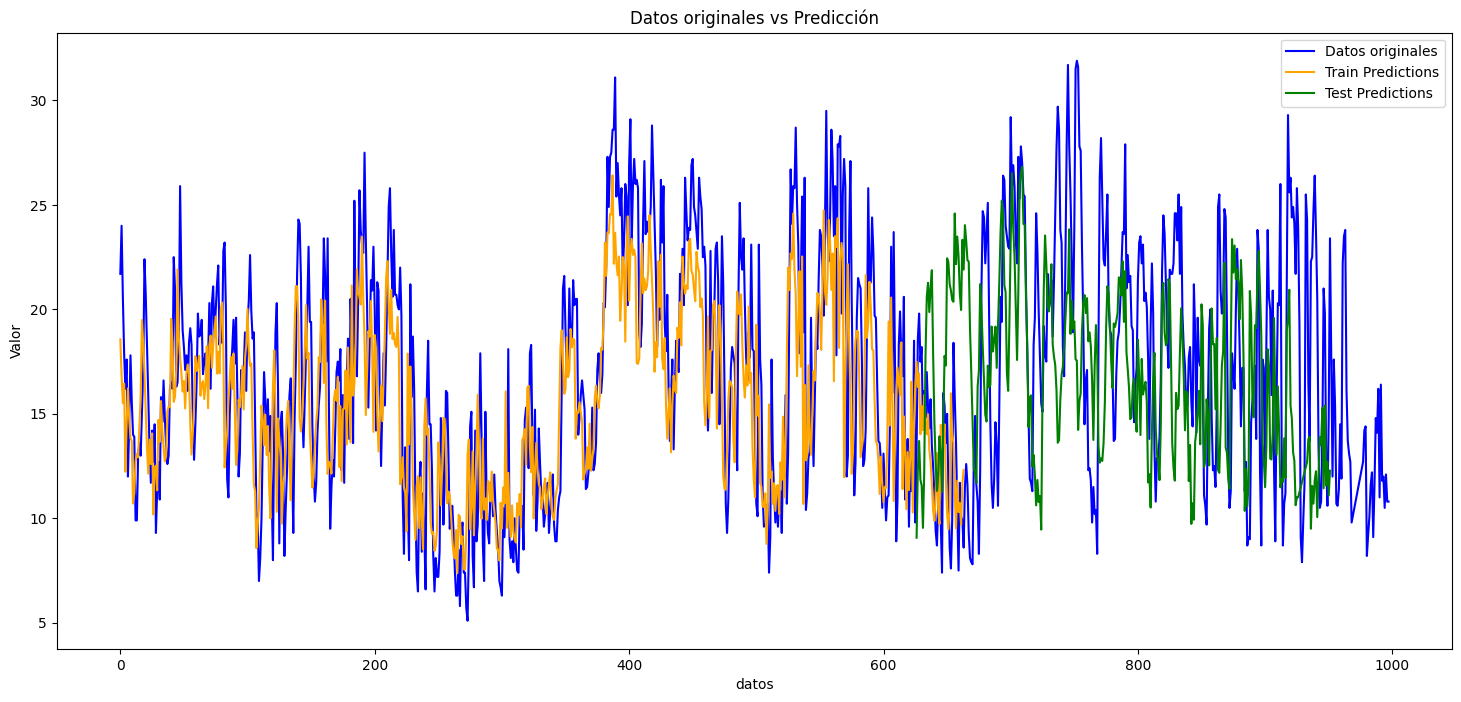

In [ ]:
# Gráfica de los datos originales y las predicciones
plt.figure(figsize=(18, 8))
plt.plot(dataset, label='Datos originales', color='blue')


# Graficar predicciones de entrenamiento
plt.plot(np.arange(len(trainPredict)), trainPredict, label='Train Predictions', color='orange')

plt.plot(np.arange(len(y_train), len(y_train) + len(testPredict)), testPredict, label='Test Predictions', color='green')
plt.legend()
plt.title('Datos originales vs Predicción')
plt.xlabel('datos')
plt.ylabel('Valor')

plt.show()


# MLP


In [ ]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
dataset = timeSerie
n_steps = 3
step_back = n_steps

train_size = int(len(dataset) * 0.67)
train_dataset, test_dataset = dataset[0:train_size], dataset[train_size:len(dataset)]

X_train, Y_train = [], []
for i in range(len(train_dataset)-step_back - 1):
    a = train_dataset[i:(i+step_back)]
    X_train.append(a)
    Y_train.append(train_dataset[i + step_back])
X_train = np.array(X_train); Y_train = np.array(Y_train);

X_test, Y_test = [], []
for i in range(len(test_dataset)-step_back - 1):
    a = test_dataset[i:(i+step_back)]
    X_test.append(a)
    Y_test.append(test_dataset[i + step_back])
X_test = np.array(X_test); Y_test = np.array(Y_test);

In [ ]:

Nodos1 = 128
Nodos2 = 64
Nodos3 = 1

model = Sequential()
model.add(Dense(Nodos1 , activation='relu', input_dim=n_steps))

model.add(Dropout(0.2))
model.add(Dense(Nodos2, activation='relu', input_dim=n_steps))
model.add(Dropout(0.2))
model.add(Dense(Nodos3, activation='linear', input_dim=n_steps))
model.compile(optimizer='adam', loss='mse') # Loss Function

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


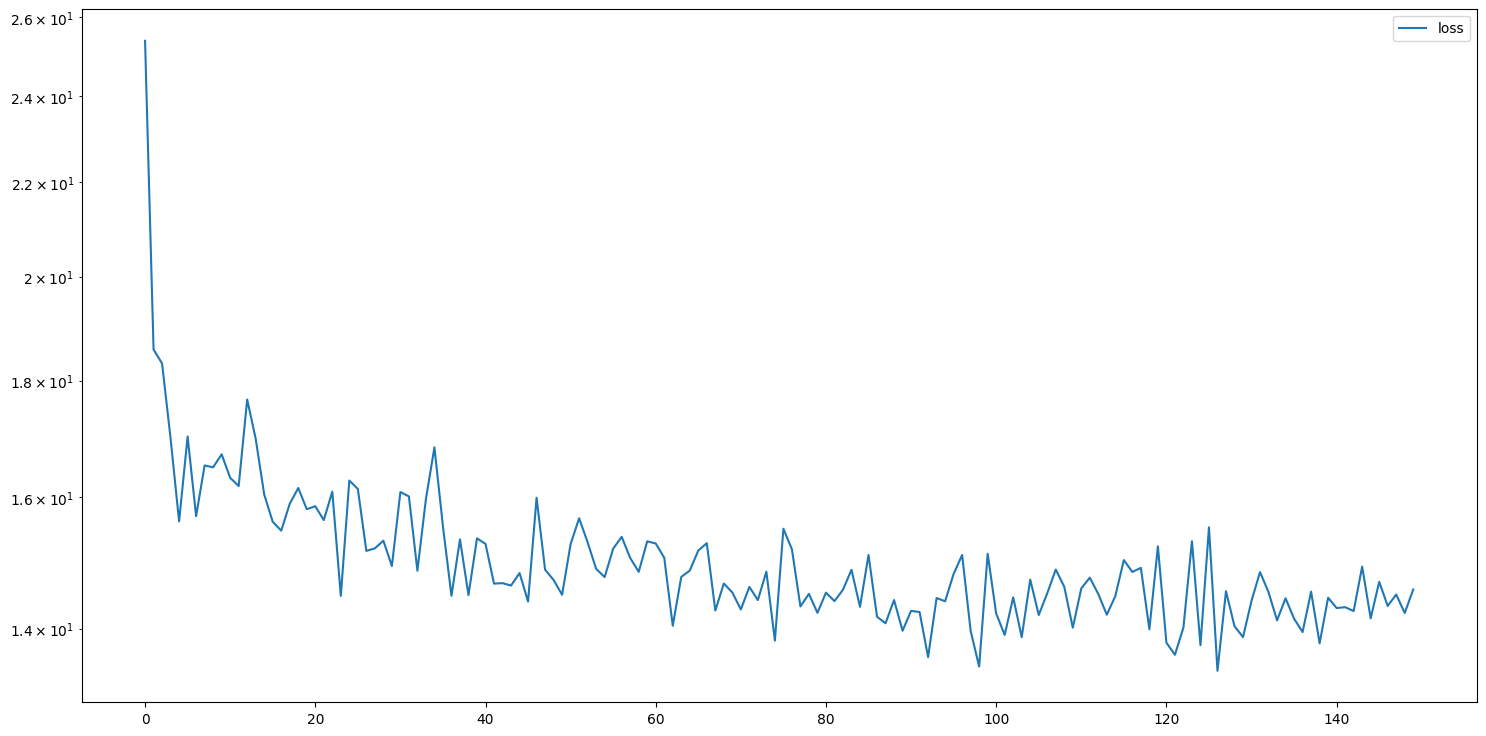

In [ ]:
X_in, y = split_sequence(X_train, n_steps)
history = model.fit(X_train, Y_train, epochs=150, batch_size=2,verbose= 0)

hpd = pd.DataFrame(history.history)
hpd[['loss']].plot(figsize=(18, 9))
plt.semilogy()
plt.show()

In [ ]:
print()
trainScore = model.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))


Train Score: 11.89 MSE (3.45 RMSE)


In [ ]:
testScore = model.evaluate(X_test, Y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Test Score: 15.03 MSE (3.88 RMSE)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


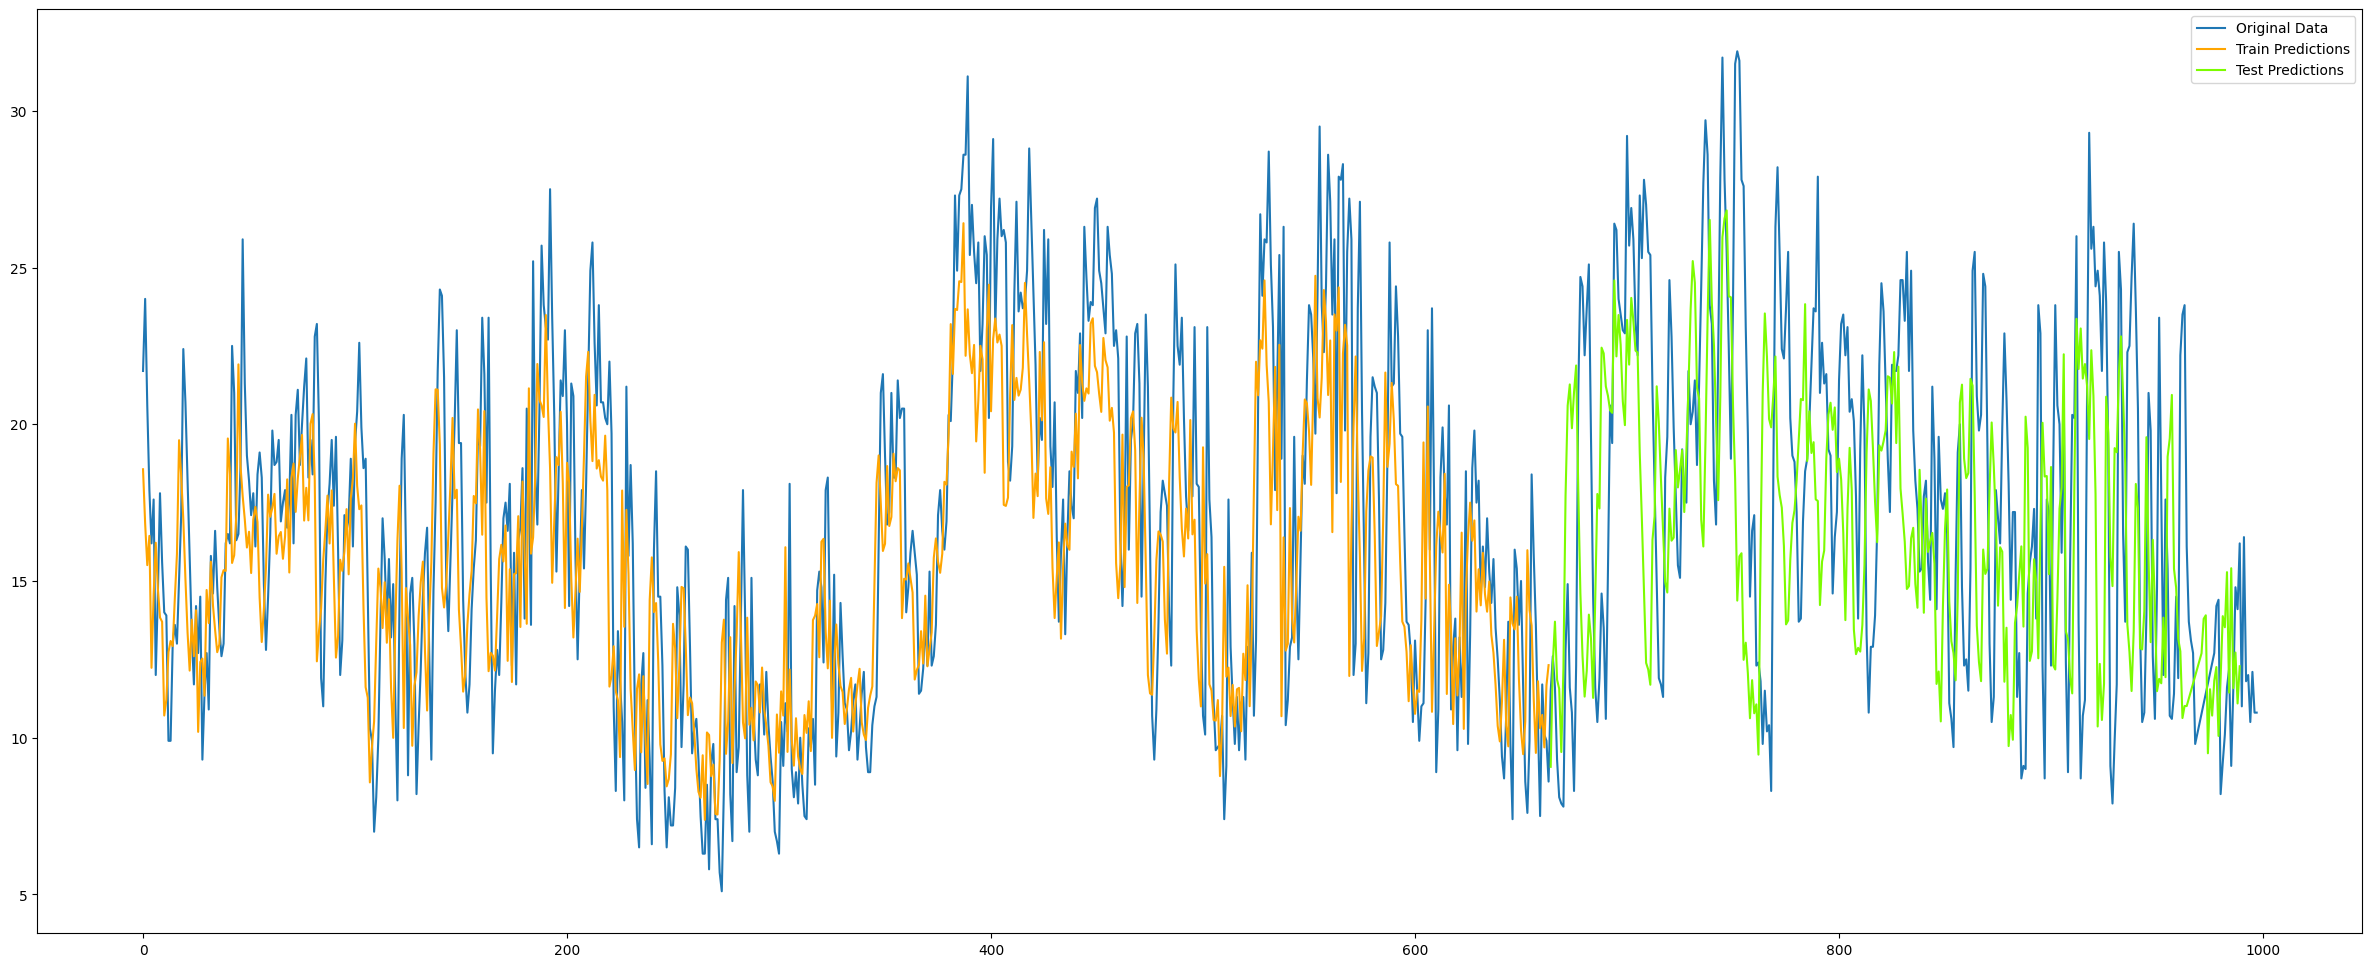

In [ ]:
# Evaluar
trainPredict = np.array(model.predict(X_train))
trainPredict = np.reshape(trainPredict, (len(trainPredict),))

testPredict = np.array(model.predict(X_test))
testPredict = np.reshape(testPredict, (len(testPredict),))

#Graficar
plt.figure(figsize=(30,12))
plt.plot(dataset, label='Original Data')

train_plot = np.empty_like(dataset)
train_plot[:] = np.nan
train_plot[:len(trainPredict)] = trainPredict

test_plot = np.empty_like(dataset)
test_plot[:] = np.nan
test_plot[len(trainPredict):(len(trainPredict)+len(testPredict))] = testPredict

# Graficar las predicciones
plt.plot(train_plot, label='Train Predictions', color='orange')
plt.plot(test_plot, label='Test Predictions', color='lawngreen')

# Añadir leyenda y mostrar el gráfico
plt.legend()
plt.show()


In [ ]:
# Estimar el modelo

# Generar ruido con la misma longitud que el dataset
noise = np.random.normal(0, 0.1, size=len(dataset))

# Agregar ruido al dataset
X_predict = dataset + noise

# Dividir la secuencia en ventanas de entrada y salida
X_predict, y_true = split_sequence(X_predict, n_steps)

# Predecir usando el modelo
y_hat = model.predict(X_predict)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


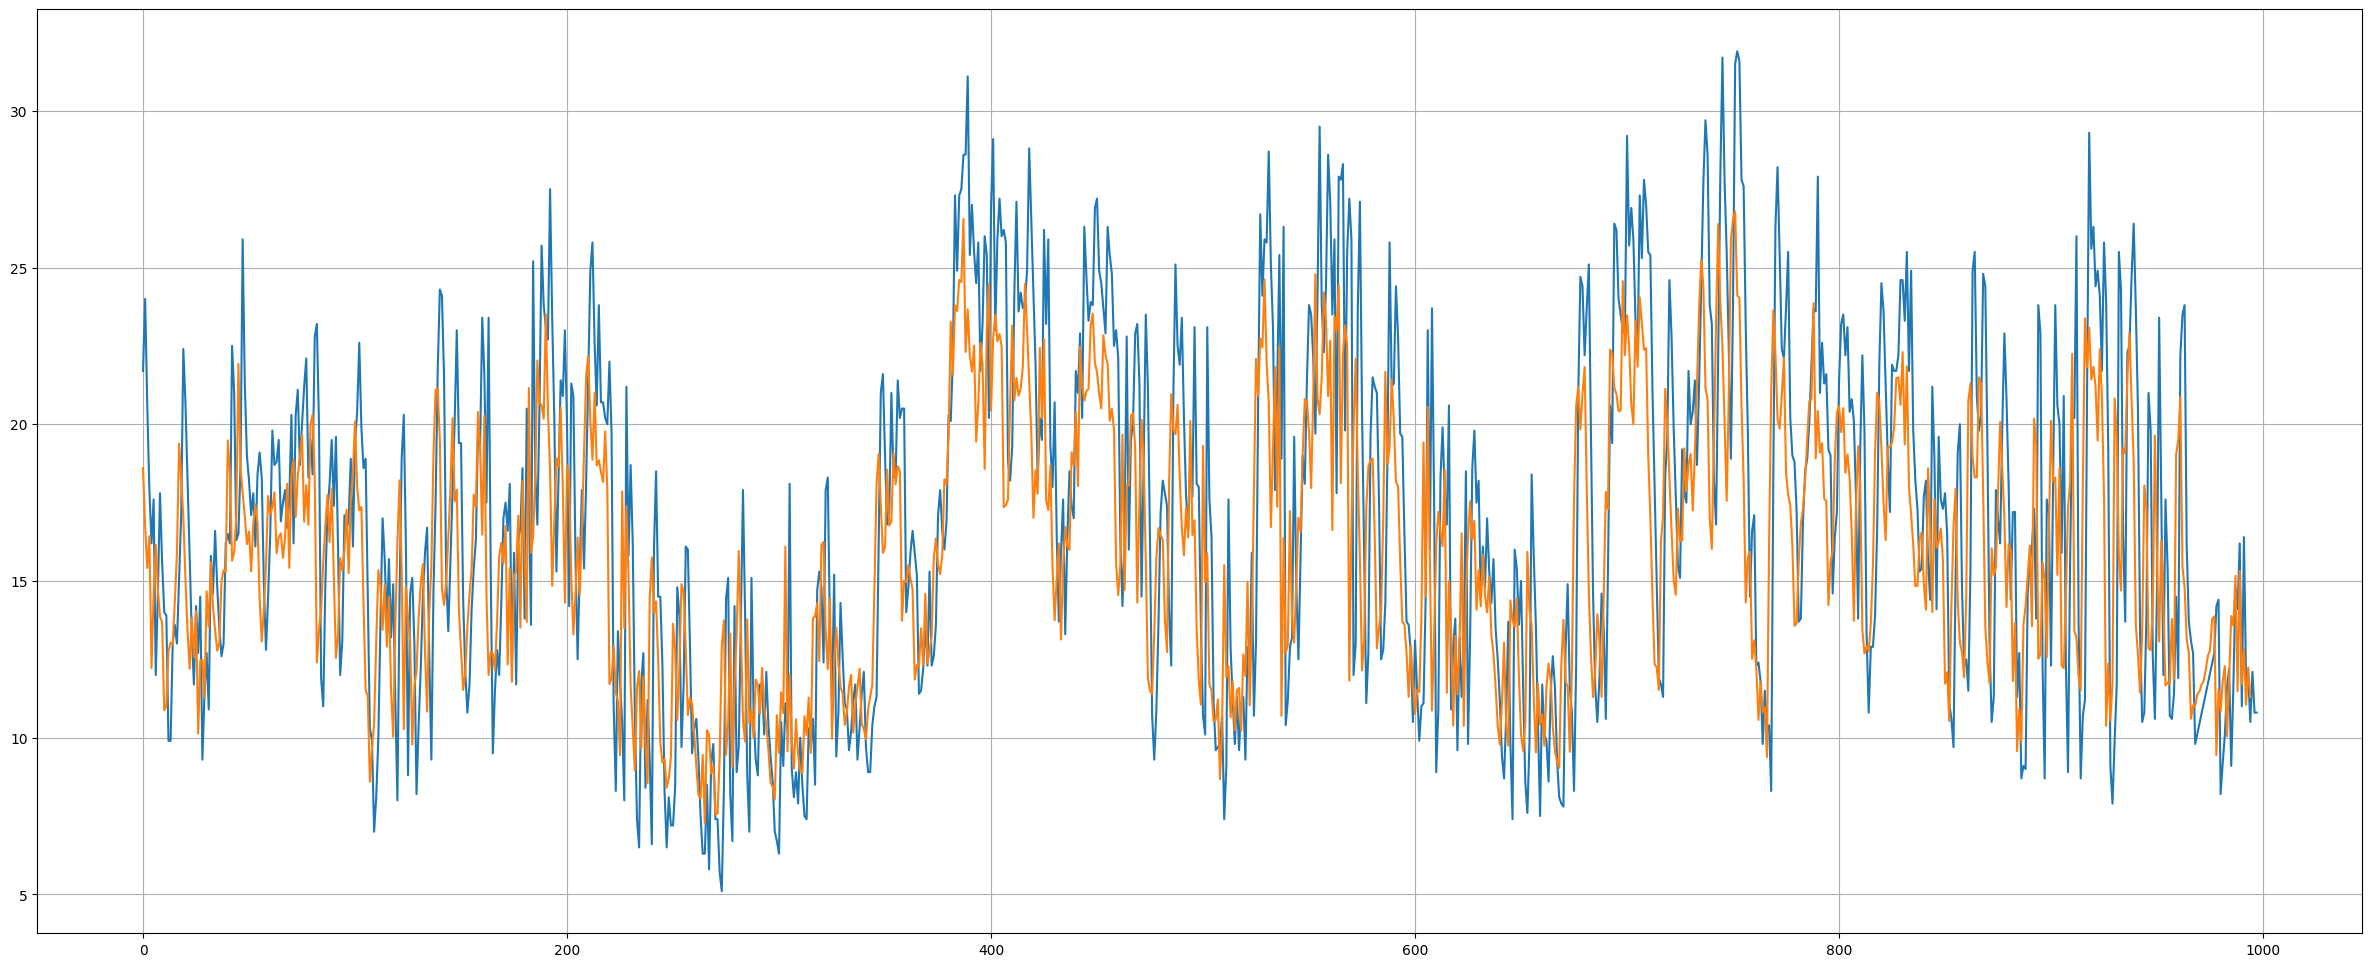

In [ ]:
plt.figure(figsize=(30,12))
plt.plot(dataset)
plt.plot(y_hat)
plt.grid()

(array([ 3.,  3.,  5., 11., 19., 17., 30., 26., 30., 55., 39., 38., 31.,
        47., 33., 35., 33., 38., 36., 43., 34., 33., 30., 41., 32., 31.,
        22., 25., 31., 35., 17., 16., 24., 11., 15.,  7.,  6.,  7.,  1.,
         0.,  1.,  4.]),
 array([ 7.2815733 ,  7.74603176,  8.21049023,  8.67494774,  9.1394062 ,
         9.60386467, 10.06832314, 10.5327816 , 10.99723911, 11.46169758,
        11.92615604, 12.39061451, 12.85507202, 13.31953049, 13.78398895,
        14.24844742, 14.71290588, 15.1773634 , 15.64182186, 16.10627937,
        16.57073784, 17.0351963 , 17.49965477, 17.96411324, 18.4285717 ,
        18.89303017, 19.35748863, 19.8219471 , 20.28640366, 20.75086212,
        21.21532059, 21.67977905, 22.14423752, 22.60869598, 23.07315445,
        23.53761292, 24.00207138, 24.46652985, 24.9309864 , 25.39544487,
        25.85990334, 26.3243618 , 26.78882027]),
 <BarContainer object of 42 artists>)

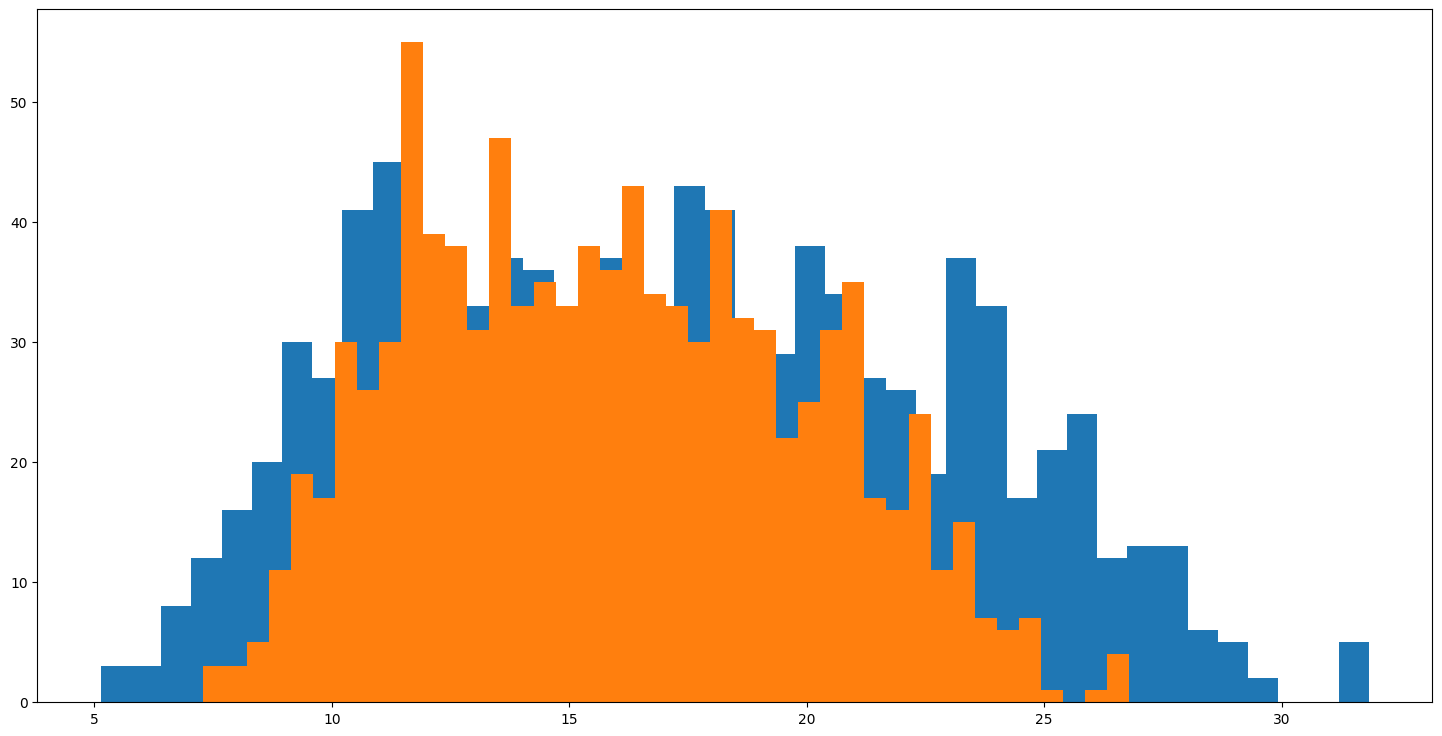

In [ ]:
plt.figure(figsize=(18,9))
plt.hist(y_true,bins=42)
plt.hist(y_hat,bins=42)